<a href="https://colab.research.google.com/github/OsvaldoSan/TSC/blob/master/Unidad_1/Ejemplo%20Transfer%20Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Dependencias

In [1]:
import tensorflow as tf
import pandas as pd
from keras import models,layers,optimizers
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
from keras.applications import VGG16
import numpy as np
import matplotlib.pyplot as plt
import os
import shutil

# Descargar dataset

### Conectar con API de Kaggle

In [18]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))
  
# Then move kaggle.json into the folder where the API expects to find it.
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 68 bytes


In [19]:
!kaggle datasets download -d tongpython/cat-and-dog

 94% 204M/218M [00:01<00:00, 102MB/s]
100% 218M/218M [00:01<00:00, 129MB/s]


In [ ]:
!unzip cat-and-dog.zip

In [27]:
!rm -rf cat_dog
!mkdir cat_dog
!mv test_set/ cat_dog
!mv training_set/ cat_dog 

In [53]:
!ls cat_dog/training_set/training_set/cats/*.jpg | wc -l # 4000 imagenes en test de gatos

4000


In [54]:
!ls cat_dog/training_set/training_set/dogs/*.jpg | wc -l # 4005 imagenes de test en perroos

4005


## Separar en validación y entrenamiento

El conjunto de datos solo trae training y test, por lo que decidi separar training en test y validacióón, esto se hace aleatoriamente con una proporción 70-30

In [42]:
ruta_train  = 'cat_dog/training_set/training_set/'
ruta_test   = 'cat_dog/test_set/test_set/'

In [74]:
# Lista de imagenes
lis_cat=[a for a in os.listdir("cat_dog/training_set/training_set/cats/") if a[-3:]=='jpg' ]
lis_dog=[a for a in os.listdir("cat_dog/training_set/training_set/dogs/") if a[-3:]=='jpg' ]

3998

In [99]:
# Función para crear listas para validación y entrenamiento
def partir_conjuntos(lista):
  tam_1=len(lista)
  tam_train=(tam_1/100)*70
  ima_val=[]
  while tam_1>tam_train:
    ima_val.append(lista.pop(np.random.randint(0,tam_1)))# Modifica directamente a lis_cat
    tam_1-=1
  return ima_val

In [103]:
cat_val=partir_conjuntos(lis_cat)
dog_val=partir_conjuntos(lis_dog)

In [141]:
# Crear directorio necesarios para mandar los nuevos archivos ahí
!rm -rf cat_dog/train
!rm -rf cat_dog/validate
!rm -rf cat_dog/train/cats
!rm -rf cat_dog/train/dogs
!rm -rf cat_dog/validate/cats
!rm -rf !mkdir cat_dog/validate/dogs
!mkdir cat_dog/train/
!mkdir cat_dog/validate/
!mkdir cat_dog/train/cats
!mkdir cat_dog/train/dogs
!mkdir cat_dog/validate/cats
!mkdir cat_dog/validate/dogs

In [140]:
# Copiar las imagenes al directorio al que deben pertenecer
def crear_datasets(lista,animal,tipo_set):
  ruta = ruta_train + animal # 'cats/'
  for c in lista:
    origen = ruta + c
    destino = 'cat_dog/'+ tipo_set + animal +c # 'train/'
  
    if os.path.exists(origen):
      with open(origen, 'rb') as forigen:
        with open(destino, 'wb') as fdestino:
          shutil.copyfileobj(forigen, fdestino)

In [145]:
crear_datasets(lis_cat,'cats/','train/')
crear_datasets(cat_val,'cats/','validate/')
crear_datasets(lis_dog,'dogs/','train/')
crear_datasets(dog_val,'dogs/','validate/')

In [151]:
!ls cat_dog/train/cats | wc -l

2800


## Red profunda desde donde se transferirá el conocimiento

In [35]:
base = VGG16(weights='imagenet', #Características aprendidas
             include_top=False, #Descartar capa densa final
             input_shape=(150,150,3))

58892288/58889256 [==============================] - 0s 0us/step


In [37]:
base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

## Creación de conjuntos de datos

In [38]:
data = ImageDataGenerator(rescale=1/255)
lote =20

In [44]:
np.zeros(2000)

array([0., 0., 0., ..., 0., 0., 0.])

In [ ]:
def extraer_caracteristicas(ruta,tam):
    vec_carac = np.zeros(shape=(tam,4,4,512)) # Crea un tensor 
    etiq = np.zeros(shape=(tam))
    print(vec_carac.shape,etiq.shape)
    generador = data.flow_from_directory(ruta,
                                         target_size=(150,150),
                                         batch_size=lote,
                                         class_mode='binary')
    i = 0
    for entradas,etiquetas in generador:
        entradas = base.predict(entradas)
        vec_carac[i*lote : (i+1)*lote] = entradas
        etiq[i*lote : (i+1)*lote] = etiquetas
        i+=1
        if i*lote>=tam:
            break
    return vec_carac,etiq

In [ ]:
Xt, yt  = extraer_caracteristicas(os.path.join(ruta,'train'),2000)

(2000, 4, 4, 512) (2000,)
Found 2000 images belonging to 2 classes.


In [ ]:
Xv, yv  = extraer_caracteristicas(os.path.join(ruta,'validate'),1000)

(1000, 4, 4, 512) (1000,)
Found 1000 images belonging to 2 classes.


In [ ]:
Xtt, ytt  = extraer_caracteristicas(os.path.join(ruta,'test'),1000)

(1000, 4, 4, 512) (1000,)
Found 1000 images belonging to 2 classes.


In [ ]:
Xt = np.reshape(Xt,(2000,4*4*512))
Xv = np.reshape(Xv,(1000,4*4*512))
Xtt = np.reshape(Xtt,(1000,4*4*512))

## Acoplamiento de capa final para adaptar al clasificador binario

In [ ]:
modelo = models.Sequential()
modelo.add(layers.Dense(256,activation='relu',input_dim=4*4*512))
modelo.add(layers.Dropout(0.5))
modelo.add(layers.Dense(1,activation='sigmoid'))
modelo.compile(optimizer = optimizers.RMSprop(learning_rate=2e-5),
              loss='binary_crossentropy',
              metrics=['acc'])
history = modelo.fit(Xt,yt,epochs=30,batch_size=lote,validation_data=(Xv,yv))

Epoch 1/30
100/100 [==============================] - 1s 13ms/step - loss: 0.6911 - acc: 0.6072 - val_loss: 0.4509 - val_acc: 0.8160
Epoch 2/30
100/100 [==============================] - 1s 10ms/step - loss: 0.4766 - acc: 0.7534 - val_loss: 0.3771 - val_acc: 0.8390
Epoch 3/30
100/100 [==============================] - 1s 10ms/step - loss: 0.3818 - acc: 0.8264 - val_loss: 0.3343 - val_acc: 0.8670
Epoch 4/30
100/100 [==============================] - 1s 10ms/step - loss: 0.3309 - acc: 0.8501 - val_loss: 0.3144 - val_acc: 0.8660
Epoch 5/30
100/100 [==============================] - 1s 10ms/step - loss: 0.2930 - acc: 0.8804 - val_loss: 0.2964 - val_acc: 0.8730
Epoch 6/30
100/100 [==============================] - 1s 10ms/step - loss: 0.2916 - acc: 0.8809 - val_loss: 0.2831 - val_acc: 0.8850
Epoch 7/30
100/100 [==============================] - 1s 11ms/step - loss: 0.2725 - acc: 0.8917 - val_loss: 0.2771 - val_acc: 0.8800
Epoch 8/30
100/100 [==============================] - 1s 11ms/step - 

## Resultados

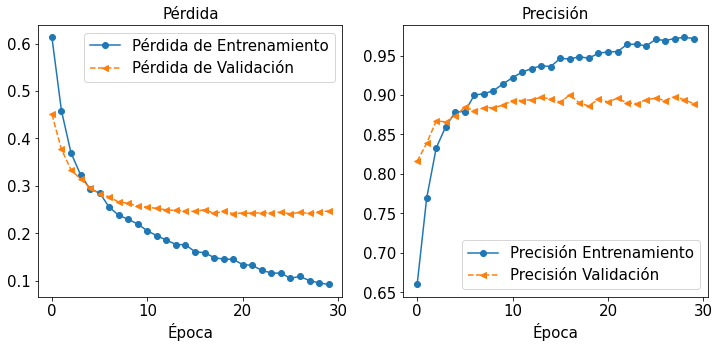

In [ ]:
hist = history.history
x_arr = np.arange(len(hist['loss']))+1
fig = plt.figure(figsize=(12,5))
ax = fig.add_subplot(1,2,1)
ax.plot(hist['loss'],'-o',label='Pérdida de Entrenamiento')
ax.plot(hist['val_loss'],'--<',label='Pérdida de Validación')
ax.set_title('Pérdida',size=15)
ax.set_xlabel('Época',size=15)
ax.tick_params(axis='both',which='major',labelsize=15)
ax.legend(fontsize=15)
ax = fig.add_subplot(1,2,2)
ax.plot(hist['acc'],'-o',label='Precisión Entrenamiento')
ax.plot(hist['val_acc'],'--<',label='Precisión Validación')
ax.set_title('Precisión',size=15)
ax.set_xlabel('Época',size=15)
ax.tick_params(axis='both',which='major',labelsize=15)
ax.legend(fontsize=15)
plt.show()